<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/SNS_data(62).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 
     |████████████████████████████████| 6.8 MB 39.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from google.colab import drive

import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertForSequenceClassification   #BERT
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification   #RoBerta
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TFGPT2LMHeadModel
from transformers import TFElectraForSequenceClassification

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/MyDrive/AIFFEL/sns_train.zip" -d "/content/sns_data"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFFEL/train/train.csv")

In [6]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [8]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [9]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

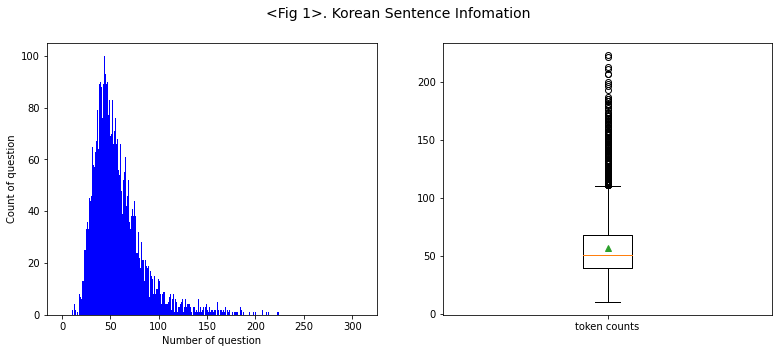

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [10]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [11]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv']

In [12]:

df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])


In [13]:
df_all["class"] = "일반 대화"

In [14]:
df_all.head()

,0,class
0,오빠 일 진짜 많네 돈 많이줌 ㅡㅡ?\n아니 ㅡㅡ 나진짜 심지어 내가 전에하던자리 ...,일반 대화
1,#@이름#이는 바1ㅡㄴ가봐 답장이 없오\n오늘부터 일하는겨?! 와..무슨 안전감시단...,일반 대화
2,아는언니가 승강기? 이쪽에 일하는데\n어 그언니한테 엘레베이터 관해서 물어봐바\n오...,일반 대화
3,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ\n진짜 답이없...,일반 대화
4,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 개막장이네 정말 오늘 11시에 과외하기로 햇는데\n또 취소함...,일반 대화


In [15]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [16]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,오빠 일 진짜 많네 돈 많이줌 ㅡㅡ?\n아니 ㅡㅡ 나진짜 심지어 내가 전에하던자리 ...
1,일반 대화,#@이름#이는 바1ㅡㄴ가봐 답장이 없오\n오늘부터 일하는겨?! 와..무슨 안전감시단...
2,일반 대화,아는언니가 승강기? 이쪽에 일하는데\n어 그언니한테 엘레베이터 관해서 물어봐바\n오...
3,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ\n진짜 답이없...
4,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 개막장이네 정말 오늘 11시에 과외하기로 햇는데\n또 취소함...
...,...,...
146551,일반 대화,뭐좀 먹었어?\n맛사지하구먹으려구 과자좀있어서먹었어 ㅋ\n글쿠나... 뭐 먹지\n떡...
146552,일반 대화,저녁 뭐먹지\n나랑 선지 고고??\n선지는 시러해서.. 국물 그닥 안땡김 더워\n그...
146553,일반 대화,불고기버거만 먹으면 배가 안차지...\n스낵랩을 추가로 시켜야지 그거만 먹진 못해\...
146554,일반 대화,ㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜ\n허니브레드 내가 그 어디서도 이렇게 겉바속촉 첨봤다ㅠㅠㅠㅠ\...


In [17]:
df_train2 = df_all.sample(n = 4000, random_state = 6)

In [18]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
29035,일반 대화,아니 걔랑 놀 때 고등학교 컨셉이라서 교무실 비트윈 불려간다고 애인 재우고 온다 아...
26599,일반 대화,집에 교촌치킨이 잇다 드소서 내가 소스를 좀 엎긴 했는대 어디놔둿어 식탁위 글쿤 안...
129194,일반 대화,설빙을 이날씨에 포장하면 집에오면 물 아닙니까 아 그럴지도 설빙은 얼음도 아니고 진...
42362,일반 대화,이름 가안간데 윾 그렇군 혼자라도가야지 나도가고싶다 나도과제극혐이야 엌 동노얘기하다...
94112,일반 대화,이름 쌤 어제 검토했던거 혹시 내용 엑셀에 정리해두셨어여 폐업 3년 초과 확인하는 ...
...,...,...
226581,일반 대화,그냥 먼나라 이야기 같애 기독교인들은 콘서트는 평생 못가뉴 에이 그건 아니지 각자 ...
87061,일반 대화,어머니능 엄마한테 물어보고 같이가지 머 걸어와 오빠가 전화좀 드려바 아들 자서 조심...
18984,일반 대화,이거 사고파 저거근뎅 왜 뽐뿌안오지 핏완전 구려보역 그랭 존옌데 내눈엔 아닌 근데또...
129107,일반 대화,코로나만 안 걸려도 올해는 잘 버틴거라고 생각할래 흑흑 맞아 진짜 건강이 최고야 또...


In [19]:
df_train2.describe()

,class,conversation
count,4000,4000
unique,1,4000
top,일반 대화,아니 걔랑 놀 때 고등학교 컨셉이라서 교무실 비트윈 불려간다고 애인 재우고 온다 아...
freq,4000,1


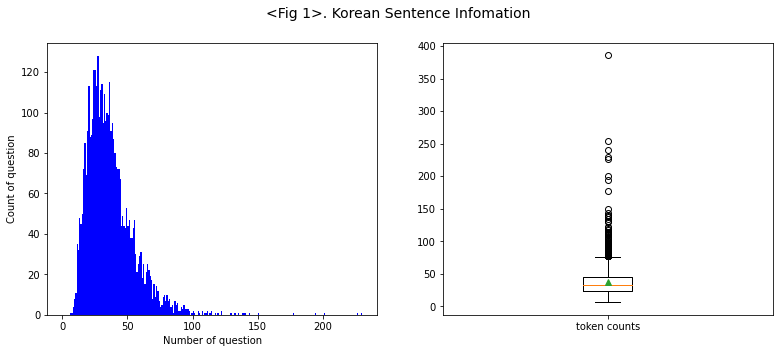

=========================================< Sentence Info >==========================================
길이 최대:     386
길이 최소:       6
길이 평균:     36.774
길이 표준편차:  20.024

 25/100분위:   24.000
 50/100분위:   33.000
 75/100분위:   45.000
 MAX/100분위:  76.500
 IQR:  21.000


In [20]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [21]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
226581,NaN,일반 대화,그냥 먼나라 이야기 같애 기독교인들은 콘서트는 평생 못가뉴 에이 그건 아니지 각자 ...
87061,NaN,일반 대화,어머니능 엄마한테 물어보고 같이가지 머 걸어와 오빠가 전화좀 드려바 아들 자서 조심...
18984,NaN,일반 대화,이거 사고파 저거근뎅 왜 뽐뿌안오지 핏완전 구려보역 그랭 존옌데 내눈엔 아닌 근데또...
129107,NaN,일반 대화,코로나만 안 걸려도 올해는 잘 버틴거라고 생각할래 흑흑 맞아 진짜 건강이 최고야 또...


In [22]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
226581,일반 대화,그냥 먼나라 이야기 같애 기독교인들은 콘서트는 평생 못가뉴 에이 그건 아니지 각자 ...
87061,일반 대화,어머니능 엄마한테 물어보고 같이가지 머 걸어와 오빠가 전화좀 드려바 아들 자서 조심...
18984,일반 대화,이거 사고파 저거근뎅 왜 뽐뿌안오지 핏완전 구려보역 그랭 존옌데 내눈엔 아닌 근데또...
129107,일반 대화,코로나만 안 걸려도 올해는 잘 버틴거라고 생각할래 흑흑 맞아 진짜 건강이 최고야 또...


In [23]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,직장 내 괴롭힘 대화,씨 자기 피아니스트야 왜 이렇게 타자 소리가 뚱땅뚱땅 소리가 크지 내가 일을 못하겠...
1,기타 괴롭힘 대화,너가 내 여자친구 좋아한다고 했냐 와 저런 오타쿠가 그랬다고 꼴값이다 진짜 내가 누...
2,기타 괴롭힘 대화,야 너 다음 시간 뭐냐 나 나 다음 시간 화학 너 체육복 있냐 체육복 응 사물함에 ...
3,기타 괴롭힘 대화,어휴 너는 머리를 왜 그따구로 묶고다니냐 응 이마에 여드름 좀 봐 더러워 뭐 뭔 자...
4,일반 대화,완전 싸게 받았네 지금 얼만데 넌 관심 없냐 6 7 이름 이 생각 해서 좀 수완 외...
...,...,...
7945,일반 대화,난 머야 오빠네 회사 인턴도 나보다 많이 버는데 니네 위는 수업 많고 나이든 시니어...
7946,일반 대화,시스템 사진 여기서 두 개 골라 사진이랑 실물이 좀 달라 나 갈색 약간 쇼핑몰에서 ...
7947,갈취 대화,야 너 돈 좀 있냐 아니 없는데 웃기지 마 니 지갑에 돈 있는 거 다 봤어 있으면 ...
7948,직장 내 괴롭힘 대화,강대리 진짜 재수없네 왜 꼬박꼬박 말대꾸에 사람을 그따위로 쳐다봐 그니까 딴 동기들...


In [24]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 100)

In [25]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df_train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

df_train["class"] = bucket_class
df_train.head()

,class,conversation
0,2,씨 자기 피아니스트야 왜 이렇게 타자 소리가 뚱땅뚱땅 소리가 크지 내가 일을 못하겠...
1,3,너가 내 여자친구 좋아한다고 했냐 와 저런 오타쿠가 그랬다고 꼴값이다 진짜 내가 누...
2,3,야 너 다음 시간 뭐냐 나 나 다음 시간 화학 너 체육복 있냐 체육복 응 사물함에 ...
3,3,어휴 너는 머리를 왜 그따구로 묶고다니냐 응 이마에 여드름 좀 봐 더러워 뭐 뭔 자...
4,4,완전 싸게 받았네 지금 얼만데 넌 관심 없냐 6 7 이름 이 생각 해서 좀 수완 외...


In [26]:
df_train.describe()

,class
count,7950.000000
mean,2.795094
std,1.446544
min,0.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,4.000000


In [27]:
X = df_train["conversation"].to_list()
Y = df_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 7155
y_train 개수 : 7155
x_val 개수 : 397
y_val 개수 : 397
x_test 개수 : 398
y_test 개수 : 398
훈련 데이터 레이블 비율 확인 : Counter({4: 3600, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 200, 3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 200, 3: 55, 2: 49, 1: 49, 0: 45})


In [28]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base", use_fast=True)

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [29]:
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

In [30]:
for key in train_encodings:
  print(f"{key} : {train_encodings[key][1]}")

input_ids : [2, 4455, 2470, 20267, 4183, 2116, 1036, 2598, 2292, 20909, 2179, 2147, 1534, 2203, 2116, 1077, 2440, 1537, 2170, 20267, 2138, 20315, 2069, 1902, 2051, 3775, 8865, 2689, 2259, 12395, 2031, 2079, 16297, 2052, 15761, 24895, 2200, 9884, 2088, 1513, 2321, 10577, 3039, 2225, 2379, 848, 6514, 3039, 2225, 864, 2019, 2116, 4920, 3732, 1642, 13964, 1460, 1521, 10426, 13964, 809, 20315, 2052, 2275, 848, 6514, 2259, 9730, 4167, 1692, 2154, 2252, 27135, 1, 1376, 1908, 3760, 8092, 3614, 3656, 3769, 2259, 3637, 20267, 2138, 1378, 2154, 2031, 2051, 732, 2116, 19655, 4033, 3072, 2180, 2778, 4224, 1535, 4616, 2052, 1378, 4541, 10577, 8339, 2079, 1535, 10716, 2530, 2052, 1415, 2051, 848, 6514, 3039, 2225, 2259, 720, 1521, 3926, 2918, 2051, 848, 6514, 2259, 6886, 3637, 850, 1567, 3681, 2259, 3885, 568, 555, 2088, 4574, 2470, 568, 3656, 578, 1039, 2227, 3783, 13964, 1929, 10577, 1097, 17649, 13679, 2299, 831, 554, 2088, 1335, 2088, 3637, 568, 2227, 3010, 2299, 18556, 801, 2116, 20315, 2367, 60

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))

In [32]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [33]:
num_labels = max(df_train["class"]) + 1
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model.compile(optimizer=optimizer, 
              loss=losses, 
              metrics=['accuracy'])

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 110,621,189
Trainable params: 110,621,189
Non-trainable params: 0
_________________________________________________________________


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

In [36]:
model.fit(
    train_dataset.shuffle(1000).batch(8), epochs=1, batch_size=8,
    validation_data=val_dataset.shuffle(1000).batch(8),
    callbacks = [callback_earlystop]
)

895/895 [==============================] - 569s 608ms/step - loss: 0.3201 - accuracy: 0.8892 - val_loss: 0.1741 - val_accuracy: 0.9496


In [37]:

model_path = "./model/fine-tuned-klue/bert-base"

model.save_pretrained(model_path)

tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue/bert-base/tokenizer_config.json',
 './model/fine-tuned-klue/bert-base/special_tokens_map.json',
 './model/fine-tuned-klue/bert-base/vocab.txt',
 './model/fine-tuned-klue/bert-base/added_tokens.json')

In [38]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue/bert-base"

loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)


text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue/bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue/bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [39]:

predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]


    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 398/398 [03:55<00:00,  1.69it/s]


In [40]:

y_pred = [int(label[-1]) for label in predicted_label_list]

y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85        45
           1       0.91      0.86      0.88        49
           2       0.87      0.94      0.90        49
           3       0.91      0.76      0.83        55
           4       1.00      0.98      0.99       200

    accuracy                           0.93       398
   macro avg       0.89      0.90      0.89       398
weighted avg       0.93      0.93      0.93       398



In [41]:

false_list = []



for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        false_list.append(i)

In [42]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
0,오 오늘 스타일 좋은데 미스 양 오늘 데이트 있나봐 네 아니 왜 어디 방이라도 잡은...,2,3
9,너 이렇게 나와서 아침마다 탕비실 청소하는 이유가 뭐야 응 깨끗하면 좋잖아 너때문에...,2,0
20,여기 희수야 하나 둘 내가 분명 삼만원 모아오라고 안했어 아니 그게 계속 모았는데 ...,3,1
42,김대리 약속한 기간이 얼마 남지 않았어 부장님 제가 그런 돈이 어딨습니까 이건 말이...,1,2
63,나 너 맘쓰이는데 더 이상 꺼내지마 맘 쓰이는데 어떻게 더 할방범이없쟈나 그러면 이...,4,2
66,이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 ...,3,0
92,어디갔다 와 회사에 있다가 바로 퇴근했는데 왜 그래 왜 칼을 들고 있어 회사 아니잖...,0,2
103,일을 왜 그딴식으로 밖에 못 해 제가 하나부터 열 가지 못 한 게 뭐가 있죠 그게 ...,0,2
105,00아 나 이것 좀 빌려줘 어 안돼 이거는 못 빌려줘 뭐 너 뭐라고 했어 못빌려줘 ...,3,1
118,선생님 음주운전 측정이있겠습니다 어 고생이 많아 후하고 불어주세요 아 나 모르나 아...,3,2


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

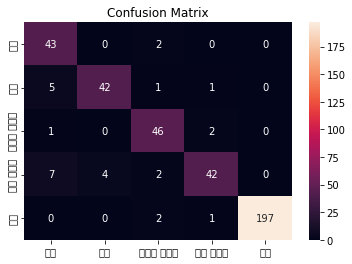

In [43]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [44]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,43,0,2,0,0
갈취,5,42,1,1,0
직장내 괴롭힘,1,0,46,2,0
기타 괴롭힘,7,4,2,42,0
일반,0,0,2,1,197


In [45]:
json_path = "/content/drive/MyDrive/AIFFEL/test/test.json"

df = pd.read_json(json_path, orient ='index')

In [46]:
test_X = df["text"].to_list()

In [47]:
predicted_label_list = []
predicted_score_list = []

for text in tqdm(test_X):
    # predict
    preds_list = text_classifier(text)[0]


    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 500/500 [05:16<00:00,  1.58it/s]


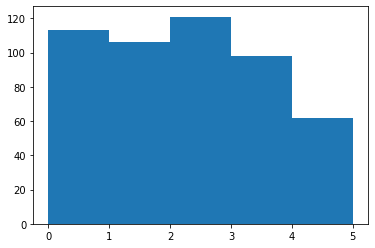

In [49]:
y_pred = [int(label[-1]) for label in predicted_label_list]

plt.hist(y_pred, bins=[0,1,2,3,4,5], histtype='bar')
plt.rc('font', family='NanumBarunGothic') 
plt.show()

In [50]:
y_pred.count(4)

62